In [1]:
import pandas as pd
from sklearn.base import TransformerMixin, BaseEstimator
pd.options.display.max_columns = 999
#pd.options.display.max_rows = 999
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import check_random_state, check_X_y
import scipy as sp
#import xgboost as xgb
#from xgboost import XGBClassifier
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
new = {'a':1,'b':2}

In [4]:
class BorutaPy(BaseEstimator, TransformerMixin):
    def __init__(self, estimator, n_estimators=1000, perc=100, alpha=0.05,
                 two_step=True, max_iter=100, random_state=None, verbose=0):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.perc = perc
        self.alpha = alpha
        self.two_step = two_step
        self.max_iter = max_iter
        self.random_state = random_state
        self.verbose = verbose

    def fit(self, X, y):
        """
        Fits the Boruta feature selection with the provided estimator.
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples.
        y : array-like, shape = [n_samples]
            The target values.
        """

        return self._fit(X, y)

    def transform(self, X, weak=False):
        """
        Reduces the input X to the features selected by Boruta.
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples.
        weak: boolean, default = False
            If set to true, the tentative features are also used to reduce X.
        Returns
        -------
        X : array-like, shape = [n_samples, n_features_]
            The input matrix X's columns are reduced to the features which were
            selected by Boruta.
        """

        return self._transform(X, weak)

    def fit_transform(self, X, y, weak=False):
        """
        Fits Boruta, then reduces the input X to the selected features.
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples.
        y : array-like, shape = [n_samples]
            The target values.
        weak: boolean, default = False
            If set to true, the tentative features are also used to reduce X.
        Returns
        -------
        X : array-like, shape = [n_samples, n_features_]
            The input matrix X's columns are reduced to the features which were
            selected by Boruta.
        """

        self._fit(X, y)
        return self._transform(X, weak)

    def _fit(self, X, y):
        # check input params
        self._check_params(X, y)
        self.random_state = check_random_state(self.random_state)
        # setup variables for Boruta
        n_sample, n_feat = X.shape
        _iter = 1
        # holds the decision about each feature:
        # 0  - default state = tentative in original code
        # 1  - accepted in original code
        # -1 - rejected in original code
        dec_reg = np.zeros(n_feat, dtype=np.int)
        # counts how many times a given feature was more important than
        # the best of the shadow features
        hit_reg = np.zeros(n_feat, dtype=np.int)
        # these record the history of the iterations
        imp_history = np.zeros(n_feat, dtype=np.float)
        sha_max_history = []

        # set n_estimators
        if self.n_estimators != 'auto':
            self.estimator.set_params(n_estimators=self.n_estimators)

        # main feature selection loop
        while np.any(dec_reg == 0) and _iter < self.max_iter:
            # find optimal number of trees and depth
            if self.n_estimators == 'auto':
                # number of features that aren't rejected
                not_rejected = np.where(dec_reg >= 0)[0].shape[0]
                n_tree = self._get_tree_num(not_rejected)
                self.estimator.set_params(n_estimators=n_tree)

            # make sure we start with a new tree in each iteration
            self.estimator.set_params(random_state=self.random_state)

            # add shadow attributes, shuffle them and train estimator, get imps
            cur_imp = self._add_shadows_get_imps(X, y, dec_reg)

            # get the threshold of shadow importances we will use for rejection
            imp_sha_max = np.percentile(cur_imp[1], self.perc)

            # record importance history
            sha_max_history.append(imp_sha_max)
            imp_history = np.vstack((imp_history, cur_imp[0]))

            # register which feature is more imp than the max of shadows
            hit_reg = self._assign_hits(hit_reg, cur_imp, imp_sha_max)

            # based on hit_reg we check if a feature is doing better than
            # expected by chance
            dec_reg = self._do_tests(dec_reg, hit_reg, _iter)

            # print out confirmed features
            if self.verbose > 0 and _iter < self.max_iter:
                self._print_results(dec_reg, _iter, 0)
            if _iter < self.max_iter:
                _iter += 1

        # we automatically apply R package's rough fix for tentative ones
        confirmed = np.where(dec_reg == 1)[0]
        tentative = np.where(dec_reg == 0)[0]
        # ignore the first row of zeros
        tentative_median = np.median(imp_history[1:, tentative], axis=0)
        # which tentative to keep
        tentative_confirmed = np.where(tentative_median
                                       > np.median(sha_max_history))[0]
        tentative = tentative[tentative_confirmed]

        # basic result variables
        self.n_features_ = confirmed.shape[0]
        self.support_ = np.zeros(n_feat, dtype=np.bool)
        self.support_[confirmed] = 1
        self.support_weak_ = np.zeros(n_feat, dtype=np.bool)
        self.support_weak_[tentative] = 1

        # ranking, confirmed variables are rank 1
        self.ranking_ = np.ones(n_feat, dtype=np.int)
        # tentative variables are rank 2
        self.ranking_[tentative] = 2
        # selected = confirmed and tentative
        selected = np.hstack((confirmed, tentative))
        # all rejected features are sorted by importance history
        not_selected = np.setdiff1d(np.arange(n_feat), selected)
        # large importance values should rank higher = lower ranks -> *(-1)
        imp_history_rejected = imp_history[1:, not_selected] * -1
        # calculate ranks in each iteration, then median of ranks across feats
        iter_ranks = self._nanrankdata(imp_history_rejected, axis=1)
        rank_medians = np.nanmedian(iter_ranks, axis=0)
        ranks = self._nanrankdata(rank_medians, axis=0)

        # update rank for not_selected features
        if not_selected.shape[0] > 0:
            # set smallest rank to 3 if there are tentative feats
            if tentative.shape[0] > 0:
                ranks = ranks - np.min(ranks) + 3
            else:
                # and 2 otherwise
                ranks = ranks - np.min(ranks) + 2
            self.ranking_[not_selected] = ranks

        # notify user
        if self.verbose > 0:
            self._print_results(dec_reg, _iter, 1)
        return self

    def _transform(self, X, weak=False):
        # sanity check
        try:
            self.ranking_
        except AttributeError:
            raise ValueError('You need to call the fit(X, y) method first.')

        if weak:
            X = X[:, self.support_ + self.support_weak_]
        else:
            X = X[:, self.support_]
        return X

    def _get_tree_num(self, n_feat):
        depth = self.estimator.get_params()['max_depth']
        if depth == None:
            depth = 10
        # how many times a feature should be considered on average
        f_repr = 100
        # n_feat * 2 because the training matrix is extended with n shadow features
        multi = ((n_feat * 2) / (np.sqrt(n_feat * 2) * depth))
        n_estimators = int(multi * f_repr)
        return n_estimators

    def _get_imp(self, X, y):
        try:
            self.estimator.fit(X, y)
        except Exception as e:
            raise ValueError('Please check your X and y variable. The provided'
                             'estimator cannot be fitted to your data.\n' + str(e))
        try:
            imp = self.estimator.feature_importances_
        except Exception:
            raise ValueError('Only methods with feature_importance_ attribute '
                             'are currently supported in BorutaPy.')
        return imp

    def _get_shuffle(self, seq):
        self.random_state.shuffle(seq)
        return seq

    def _add_shadows_get_imps(self, X, y, dec_reg):
        # find features that are tentative still
        x_cur_ind = np.where(dec_reg >= 0)[0]
        x_cur = np.copy(X[:, x_cur_ind])
        x_cur_w = x_cur.shape[1]
        # deep copy the matrix for the shadow matrix
        x_sha = np.copy(x_cur)
        # make sure there's at least 5 columns in the shadow matrix for
        while (x_sha.shape[1] < 5):
            x_sha = np.hstack((x_sha, x_sha))
        # shuffle xSha
        x_sha = np.apply_along_axis(self._get_shuffle, 0, x_sha)
        # get importance of the merged matrix
        imp = self._get_imp(np.hstack((x_cur, x_sha)), y)
        # separate importances of real and shadow features
        imp_sha = imp[x_cur_w:]
        imp_real = np.zeros(X.shape[1])
        imp_real[:] = np.nan
        imp_real[x_cur_ind] = imp[:x_cur_w]
        return imp_real, imp_sha

    def _assign_hits(self, hit_reg, cur_imp, imp_sha_max):
        # register hits for features that did better than the best of shadows
        cur_imp_no_nan = [val for val in cur_imp[0] if not np.isnan(val)]
        hits = np.where(cur_imp_no_nan > imp_sha_max)[0]
        hit_reg[hits] += 1
        return hit_reg

    def _do_tests(self, dec_reg, hit_reg, _iter):
        active_features = np.where(dec_reg >= 0)[0]
        hits = hit_reg[active_features]
        # get uncorrected p values based on hit_reg
        to_accept_ps = sp.stats.binom.sf(hits - 1, _iter, .5).flatten()
        to_reject_ps = sp.stats.binom.cdf(hits, _iter, .5).flatten()

        if self.two_step:
            # two step multicor process
            # first we correct for testing several features in each round using FDR
            to_accept = self._fdrcorrection(to_accept_ps, alpha=self.alpha)[0]
            to_reject = self._fdrcorrection(to_reject_ps, alpha=self.alpha)[0]

            # second we correct for testing the same feature over and over again
            # using bonferroni
            to_accept2 = to_accept_ps <= self.alpha / float(_iter)
            to_reject2 = to_reject_ps <= self.alpha / float(_iter)

            # combine the two multi corrections, and get indexes
            to_accept *= to_accept2
            to_reject *= to_reject2
        else:
            # as in th original Boruta, we simply do bonferroni correction
            # with the total n_feat in each iteration
            to_accept = to_accept_ps <= self.alpha / float(len(dec_reg))
            to_reject = to_reject_ps <= self.alpha / float(len(dec_reg))

        # find features which are 0 and have been rejected or accepted
        to_accept = np.where((dec_reg[active_features] == 0) * to_accept)[0]
        to_reject = np.where((dec_reg[active_features] == 0) * to_reject)[0]

        # updating dec_reg
        dec_reg[active_features[to_accept]] = 1
        dec_reg[active_features[to_reject]] = -1
        return dec_reg

    def _fdrcorrection(self, pvals, alpha=0.05):
        """
        Benjamini/Hochberg p-value correction for false discovery rate, from
        statsmodels package. Included here for decoupling dependency on statsmodels.
        Parameters
        ----------
        pvals : array_like
            set of p-values of the individual tests.
        alpha : float
            error rate
        Returns
        -------
        rejected : array, bool
            True if a hypothesis is rejected, False if not
        pvalue-corrected : array
            pvalues adjusted for multiple hypothesis testing to limit FDR
        """
        pvals = np.asarray(pvals)
        pvals_sortind = np.argsort(pvals)
        pvals_sorted = np.take(pvals, pvals_sortind)
        nobs = len(pvals_sorted)
        ecdffactor = np.arange(1, nobs + 1) / float(nobs)

        reject = pvals_sorted <= ecdffactor * alpha
        if reject.any():
            rejectmax = max(np.nonzero(reject)[0])
            reject[:rejectmax] = True

        pvals_corrected_raw = pvals_sorted / ecdffactor
        pvals_corrected = np.minimum.accumulate(pvals_corrected_raw[::-1])[::-1]
        pvals_corrected[pvals_corrected > 1] = 1
        # reorder p-values and rejection mask to original order of pvals
        pvals_corrected_ = np.empty_like(pvals_corrected)
        pvals_corrected_[pvals_sortind] = pvals_corrected
        reject_ = np.empty_like(reject)
        reject_[pvals_sortind] = reject
        return reject_, pvals_corrected_

    def _nanrankdata(self, X, axis=1):
        """
        Replaces bottleneck's nanrankdata with scipy and numpy alternative.
        """
        ranks = sp.stats.mstats.rankdata(X, axis=axis)
        ranks[np.isnan(X)] = np.nan
        return ranks

    def _check_params(self, X, y):
        """
        Check hyperparameters as well as X and y before proceeding with fit.
        """
        # check X and y are consistent len, X is Array and y is column
        X, y = check_X_y(X, y)
        if self.perc <= 0 or self.perc > 100:
            raise ValueError('The percentile should be between 0 and 100.')

        if self.alpha <= 0 or self.alpha > 1:
            raise ValueError('Alpha should be between 0 and 1.')

    def _print_results(self, dec_reg, _iter, flag):
        n_iter = str(_iter) + ' / ' + str(self.max_iter)
        n_confirmed = np.where(dec_reg == 1)[0].shape[0]
        n_rejected = np.where(dec_reg == -1)[0].shape[0]
        cols = ['Iteration: ', 'Confirmed: ', 'Tentative: ', 'Rejected: ']

        # still in feature selection
        if flag == 0:
            n_tentative = np.where(dec_reg == 0)[0].shape[0]
            content = map(str, [n_iter, n_confirmed, n_tentative, n_rejected])
            if self.verbose == 1:
                output = cols[0] + n_iter
            elif self.verbose > 1:
                output = '\n'.join([x[0] + '\t' + x[1] for x in zip(cols, content)])

        # Boruta finished running and tentatives have been filtered
        else:
            n_tentative = np.sum(self.support_weak_)
            content = map(str, [n_iter, n_confirmed, n_tentative, n_rejected])
            result = '\n'.join([x[0] + '\t' + x[1] for x in zip(cols, content)])
            output = "\n\nBorutaPy finished running.\n\n" + result
        print(output)

In [61]:
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

In [2]:
#external data (distance to public transport)
df_transport = pd.read_excel('../data/excel/RentalPropertiesWithDistanceToPublicRails.xlsx')

#pre-processing data
df_rental = pd.read_csv("../data/processed/Propwall_Report_ForRent-26-3-18.csv")
df_rental["State"] = df_rental['State'].apply(lambda x: x if x != 'Petaling Jaya' else 'Selangor')

#add column of quarter and year-quarter
df_rental['quarter'] = ((df_rental['month']-1)//3+1)
df_rental['year-quarter'] = df_rental['year'].astype(str) + '-' + df_rental['quarter'].astype(str)

#merge external data with rental data
df_merged = df_rental.merge(df_transport, on = 'Location_property', how = 'left')

#choose KL and Selangor
df_merged_KlSel = df_merged[df_merged['State'].isin(['Kuala Lumpur','Selangor'])].copy()

In [3]:
def VicinityToPT(df,transportType,threshold = 0.8):
    if [i for i in df_merged_KlSel.columns if 'dist-to-{}'.format(transportType) in i]:
        return np.any([df[i]<threshold for i in df_merged_KlSel.columns if 'dist-to-{}'.format(transportType) in i])
    #else:
        #print(transportType + ' not found in dataframe columns')

df_merged_KlSel['ClosetoLRT'] = df_merged_KlSel.apply(VicinityToPT,transportType = 'LRT',axis = 1)
df_merged_KlSel['ClosetoKTM'] = df_merged_KlSel.apply(VicinityToPT,transportType = 'KTM',axis = 1)
df_merged_KlSel['ClosetoMRT'] = df_merged_KlSel.apply(VicinityToPT,transportType = 'MRT',axis = 1)
df_merged_KlSel['ClosetoMonorail'] = df_merged_KlSel.apply(VicinityToPT,transportType = 'Monorail',axis = 1)

In [12]:
columnNames_list = ['price','size','bath','carpark','num_bedroom',
                   'ClosetoLRT','ClosetoKTM','ClosetoMRT','ClosetoMonorail']

# make dummy variables out of categorical variables
df_merged_Kl = df_merged_KlSel[df_merged_KlSel['State'] == 'Kuala Lumpur'].copy()

#if there is categorical column
#df_categoricalV = pd.get_dummies(df_merged_Kl[[i for i in df_merged_Kl.columns if df_merged_Kl[i].dtype == 'object']])

df_numericalV = df_merged_Kl[[i for i in df_merged_Kl.columns if df_merged_Kl[i].dtype != 'object']]

#df_X = pd.concat([df_numericalV,df_categoricalV],join_axes= [df_numericalV.index],axis = 1)

In [16]:
X_array = df_numericalV.values
Y_array = df_merged_Kl['price'].values
Y_array

array([ 1950.,  2200.,  1200., ...,  1500.,  1500.,  2300.])

In [15]:
df_merged_Kl.shape

(144227, 190)

In [86]:
feat_selector.fit(X_array, Y_array)

feat_selector.support_

feat_selector.ranking_

feat_selector.

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	4
Tentative: 	0
Rejected: 	0


TypeError: iteration over a 0-d array

In [ ]:
4:42
#feature selection using xgboost
#based on importance score
xgbC = XGBClassifier(nthread = 4)
xgbC.fit(X_array, Y_array)

In [ ]:
xgbC.feature_importances_

# Multiple Linear Regression (ols)

In [2]:
df_star = pd.read_csv('../data/processed/df_fullfeatures.csv')

In [3]:
features_list = ['furnishing','num_bedroom','num_bath',
                'size','region_type','ClosetoLRT','ClosetoKTM',
                'ClosetoMRT','ClosetoMonorail']

In [4]:
#if there is categorical column
df_categoricalV = pd.get_dummies(df_star[[i for i in features_list if df_star[i].dtype == 'object']])

df_numericalV = df_star[[i for i in features_list if df_star[i].dtype != 'object']]

df_features = pd.concat([df_numericalV,df_categoricalV],join_axes= [df_numericalV.index],axis = 1).copy()

In [83]:
import statsmodels.api as sm
model = sm.OLS(np.log(df_star['price']),df_features)

In [84]:
trainedModel = model.fit()

In [114]:
df_features['price'] = np.log(df_star['price'])

In [115]:
corr_matrix = df_features.corr()

In [116]:
corr_matrix

num_bedroom  num_bath      size  \
num_bedroom                    1.000000  0.729046  0.762182   
num_bath                       0.729046  1.000000  0.629984   
size                           0.762182  0.629984  1.000000   
furnishing_Fully Furnished    -0.080441 -0.066648 -0.032385   
furnishing_Semi-Furnished     -0.000801  0.002781 -0.016691   
furnishing_Unfurnished         0.066744  0.038543  0.045230   
region_type_Central            0.030538  0.021960  0.036810   
region_type_Gombak            -0.001522  0.001335  0.006672   
region_type_Hulu Langat       -0.033498 -0.028266 -0.038133   
region_type_Hulu Selangor      0.008385  0.001355  0.007221   
region_type_Klang             -0.003881 -0.006997 -0.019060   
region_type_Kuala Langat       0.010294  0.011216  0.008823   
region_type_Kuala Selangor    -0.043040 -0.024761  0.006130   
region_type_North             -0.021948 -0.009057  0.000896   
region_type_Petaling           0.025736  0.007805  0.028859   
region_type_Sepang            -0.018090 -0.032129 -0.040674   
region_type_South             -0.016683 -0.012543 -0.005551   
ClosetoLRT_False               0.007166  0.010387  0.023839   
ClosetoLRT_True                0.014246 -0.001208  0.003962   
ClosetoKTM_False               0.035567  0.024165  0.033061   
ClosetoKTM_True               -0.037123 -0.029047 -0.011750   
ClosetoMRT_False               0.017747  0.013223  0.031614   
ClosetoMRT_True               -0.001072 -0.006584 -0.008587   
ClosetoMonorail_False          0.021074  0.014312  0.034617   
ClosetoMonorail_True          -0.008789 -0.010642 -0.017145   
price                          0.691531  0.560668  0.865751   

                            furnishing_Fully Furnished  \
num_bedroom                                  -0.080441   
num_bath                                     -0.066648   
size                                         -0.032385   
furnishing_Fully Furnished                    1.000000   
furnishing_Semi-Furnished                    -0.411800   
furnishing_Unfurnished                       -0.363041   
region_type_Central                           0.012000   
region_type_Gombak                           -0.004728   
region_type_Hulu Langat                      -0.008769   
region_type_Hulu Selangor                    -0.003425   
region_type_Klang                            -0.027462   
region_type_Kuala Langat                      0.003044   
region_type_Kuala Selangor                   -0.001547   
region_type_North                             0.033227   
region_type_Petaling                          0.019816   
region_type_Sepang                            0.012274   
region_type_South                             0.036822   
ClosetoLRT_False                             -0.003598   
ClosetoLRT_True                               0.022023   
ClosetoKTM_False                             -0.000724   
ClosetoKTM_True                               0.024986   
ClosetoMRT_False                              0.000928   
ClosetoMRT_True                               0.020427   
ClosetoMonorail_False                         0.003635   
ClosetoMonorail_True                          0.019885   
price                                         0.051695   

                            furnishing_Semi-Furnished  furnishing_Unfurnished  \
num_bedroom                                 -0.000801                0.066744   
num_bath                                     0.002781                0.038543   
size                                        -0.016691                0.045230   
furnishing_Fully Furnished                  -0.411800               -0.363041   
furnishing_Semi-Furnished                    1.000000               -0.658071   
furnishing_Unfurnished                      -0.658071                1.000000   
region_type_Central                         -0.010900               -0.001861   
region_type_Gombak                          -0.012685                0.017928   
region_type_Hulu Langat       

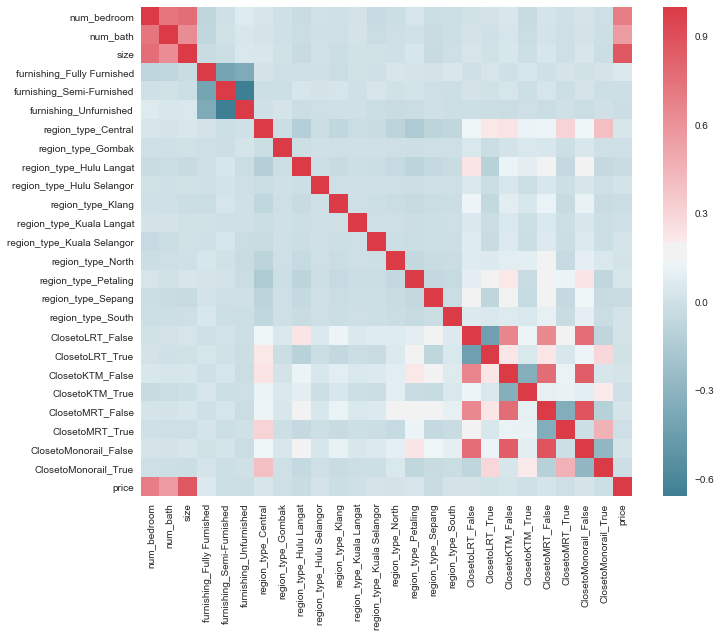

In [118]:
sns.set(style="white")
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_matrix,cmap = cmap)
f.savefig('../data/processed/heatmap_Sales_corr.png',bbox_inches = 'tight')

In [86]:
trainedModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 1.932e+06
Date:                Thu, 31 May 2018   Prob (F-statistic):               0.00
Time:                        17:19:46   Log-Likelihood:            -1.0277e+06
No. Observations:              559660   AIC:                         2.056e+06
Df Residuals:                  559638   BIC:                         2.056e+06
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
num_bedroom                    0.8307      0.003    238.873      0.000       0.824       0.838
num_bath                       0.5259      0.004    130.310      0.000       0.518       0.534
size                          -0.0001    3.1e-06    -41.977      0.000      -0.000      -0.000
furnishing_Fully Furnished     9.2741      0.009   1087.670      0.000       9.257       9.291
furnishing_Semi-Furnished      9.0221      0.008   1120.373      0.000       9.006       9.038
furnishing_Unfurnished         8.9559      0.008   1090.818      0.000       8.940       8.972
region_type_Central            0.0600      0.007      8.720      0.000       0.047       0.074
region_type_Gombak            -0.1179      0.041     -2.845      0.004      -0.199      -0.037
region_type_Hulu Langat        0.0073      0.009      0.799      0.425      -0.011       0.025
region_type_Hulu Selangor     -0.0166      0.043     -0.386      0.699      -0.101       0.068
region_type_Klang             -0.0375      0.015     -2.583      0.010      -0.066      -0.009
region_type_Kuala Langat      -0.1716      0.037     -4.667      0.000      -0.244      -0.100
region_type_Kuala Selangor     0.7750      0.026     29.342      0.000       0.723       0.827
region_type_North              0.2057      0.012     16.768      0.000       0.182       0.230
region_type_Petaling           0.0184      0.008      2.306      0.021       0.003       0.034
region_type_Sepang             0.0418      0.012      3.527      0.000       0.019       0.065
region_type_South              0.1435      0.016      9.165      0.000       0.113       0.174
ClosetoLRT_False               0.1527      0.004     40.671      0.000       0.145       0.160
ClosetoLRT_True                0.1162      0.004     26.682      0.000       0.108       0.125
ClosetoKTM_False               0.0667      0.004     15.645      0.000       0.058       0.075
ClosetoKTM_True                0.2021      0.006     36.216      0.000       0.191       0.213
ClosetoMRT_False               0.1394      0.005     29.248      0.000       0.130       0.149
ClosetoMRT_True                0.1294      0.006     22.629      0.000       0.118       0.141
ClosetoMonorail_False          0.1706      0.006     28.136      0.000       0.159       0.182
ClosetoMonorail_True           0.0983      0.008     12.740      0.000       0.083       0.113
==============================================================================
Omnibus:                   455566.450   Durbin-Watson:                   1.540
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12011205.989
Skew:                           3.849   Prob(JB):                         0.00
Kurtosis:                      24.350   Cond. No.                     3.24e+18
============================

In [5]:
from sklearn.cross_validation import cross_val_predict,cross_val_score
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import linear_model
X_train, X_test, Y_train, Y_test = train_test_split(df_features,df_star['price'],
                                                   test_size = 0.2)

In [76]:
lm = linear_model.LinearRegression()
linearModel = lm.fit(X_train,Y_train)

In [77]:
predictions = linearModel.predict(X_test)

In [63]:
#r2 score
print('in-sample score: ' + str(linearModel.score(X_train,Y_train)))
print('out-sample score: ' + str(linearModel.score(X_test,Y_test)))

in-sample score: 0.840084482412
out-sample score: 0.838958853333


In [78]:
mean_squared_error(Y_test,predictions)

44123896574.640137

In [82]:
#K fold validation to evaluate model's performance
kf = KFold(n_splits = 3)
result_list = []
for train_index, test_index in kf.split(df_features):
    lm = linear_model.LinearRegression()
    X_train, X_test = df_features.values[train_index], df_features.values[test_index]
    Y_train, Y_test = df_star['price'].values[train_index], df_star['price'].values[test_index]
    model = lm.fit(X_train,Y_train)
    pred = model.predict(X_test)
    result_list.append(mean_squared_error(Y_test,pred))
rmse = np.sqrt(np.sum(result_list))
print('RMSE: ' + str(rmse))
#equilvalent to cross_val_score(lm,X_train,Y_train,scoring = 'neg_mean_squared_error')

RMSE: 348252.661308
